In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_columns', None)
import numpy as np
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from shapely.geometry import Point
# from tqdm import tqdm

In [3]:
df = pd.read_csv("Police Stops vs Accidents - width=0.005 - 2021-04-02.csv")

In [9]:
# gdf = gpd.GeoDataFrame(df, geometry=df['geometry'])

TypeError: Input must be valid geometry objects: POINT (-77.455 39.425)

In [ ]:
gdf = gpd.read_file("Police Stops vs Accidents - width=0.005 - 2021-04-02.csv")

# Analysis

## Total_Stops vs. Stops_per_Accident

C:\Users\mikha\Anaconda\envs\geopandas_env\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

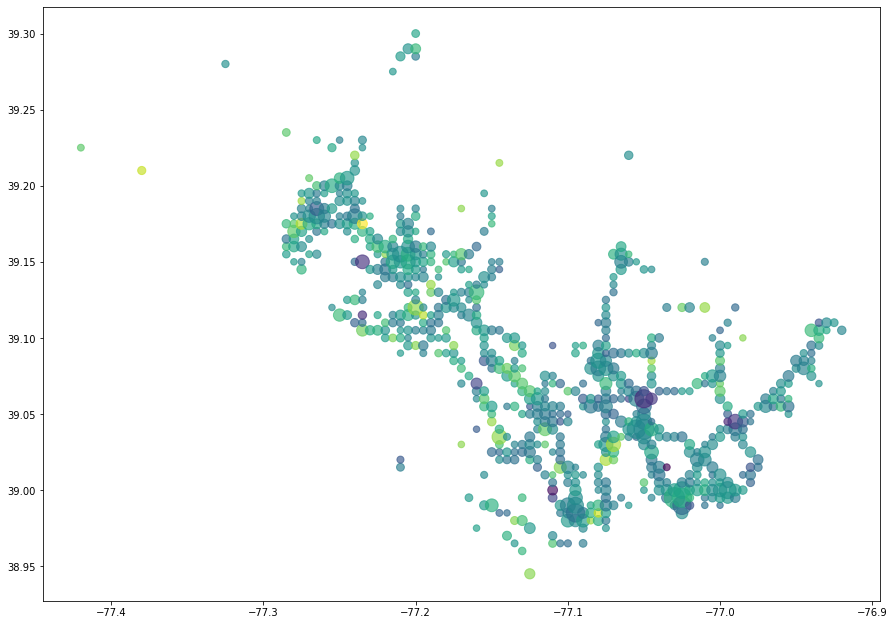

In [64]:
filter_gdf = gdf[(gdf['Total_Stops']>300)]
# filter_gdf = gdf[(gdf['Stops_per_Accident']<150) & (gdf['Total_Stops']>300)]

filter_gdf.plot(markersize=np.power(filter_gdf['Total_Stops'], 0.65), figsize=(15,15), c=np.log(filter_gdf['Stops_per_Accident']), alpha=.65, legend=True)

## Raw, unweighted correlation betwen Stops and Accidents

In [65]:
gdf['Total_Stops'].corr(gdf['Total_Accidents'])

0.4769933604849849

## Let's plot Total_Accidents vs. Total_Stops in each tile

In [3]:
df['Total_Accidents'].max()

3295

<AxesSubplot:xlabel='Total_Stops', ylabel='Total_Accidents'>

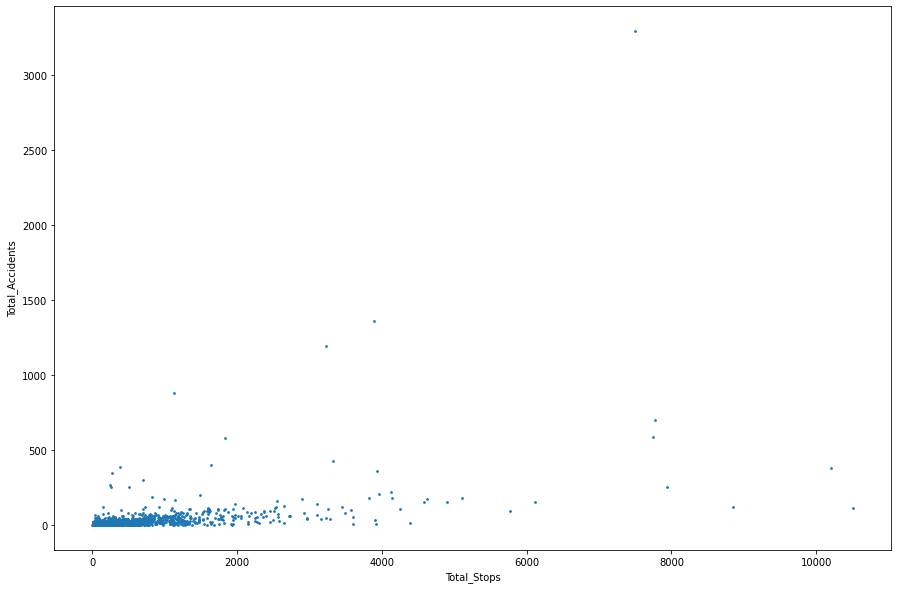

In [66]:
geo_df.plot(kind='scatter', x="Total_Stops", y="Total_Accidents", s=3, figsize=(15,10))

## Let's zoom in so we can see if there's a pattern on the bottom-left of this ^^ (where most tiles are)

Text(0.5, 1.0, 'Total Accidents vs. Stops')

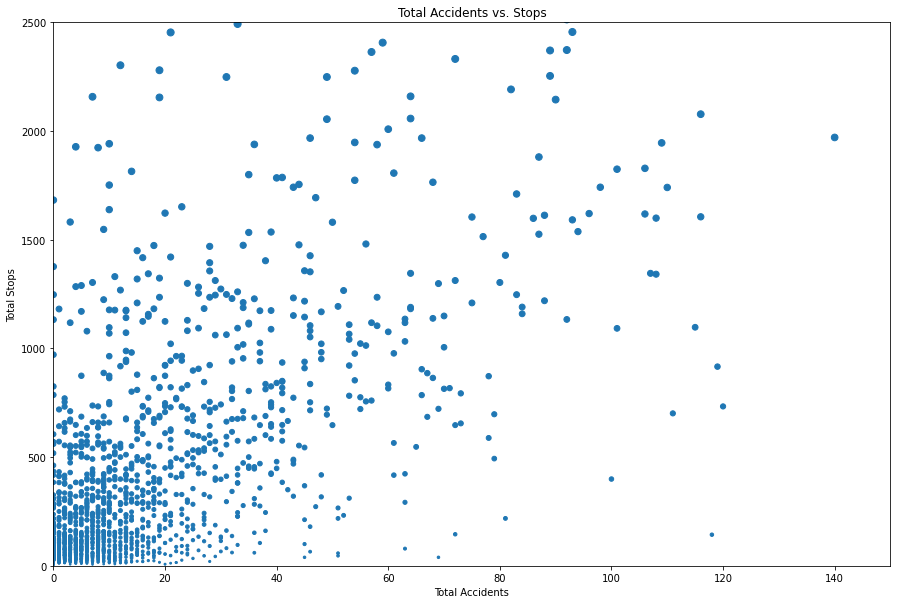

In [17]:
fig, ax1 = plt.subplots()

geo_df.plot(kind='scatter', y="Total_Stops", x="Total_Accidents", s=np.power(geo_df['Total_Stops'], .5), figsize=(15,10), ylim=(0,2500), xlim=(0,150), ax=ax1, legend=True)

plt.title("Total_Accidents vs. Stops")

## We can see a very loose relationship, if any

### Weighted corr (probably wrong)

In [233]:
# np.cov(geo_df['Total_Accidents'], geo_df['Total_Stops'], fweights=geo_df['Total_Stops'])

# weighted_VAR_total_accidents = np.cov(geo_df['Total_Accidents'], geo_df['Total_Stops'], fweights=geo_df['Total_Stops'])[0,0]
# weighted_VAR_total_stops = np.cov(geo_df['Total_Accidents'], geo_df['Total_Stops'], fweights=geo_df['Total_Stops'])[1,1]
# weighted_COV_total_accidents_stops = np.cov(geo_df['Total_Accidents'], geo_df['Total_Stops'], fweights=geo_df['Total_Stops'])[0,1]

# weighted_CORR_total_accidents_stops = weighted_COV_total_accidents_stops / (weighted_VAR_total_accidents * weighted_VAR_total_stops)
# corr_str = format(weighted_CORR_total_accidents_stops, 'f')
# print(f'Weighted correlation between Total_Accidents and Total_Stops is approx {corr_str}. MAYBE - DUBIOUS')

## Truncated Plot

Let's look at the plot after cutting away all tiles with less stops than a set lower bound

In [23]:
lower_bound = 600

pct_of_stops_above_lower_bound = 100 * ( geo_df[geo_df['Total_Stops'] > lower_bound]['Total_Stops'].sum() / geo_df['Total_Stops'].sum())

print(f'{round(pct_of_stops_above_lower_bound, 2)}% of stops are in tiles with over {lower_bound} stops')

72.39% of stops are in tiles with over 600 stops


Text(0.5, 1.0, 'Total_Accidents vs. Stops \n Size = Total Stops \n Color = Citations Per Stop')

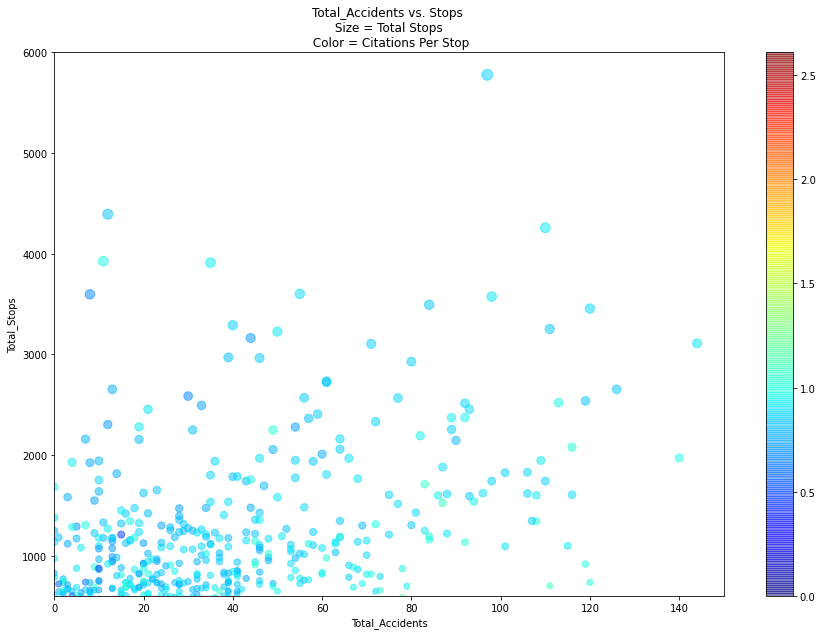

In [157]:
fig, ax1 = plt.subplots()

geo_df.plot(kind='scatter', y="Total_Stops", x="Total_Accidents", s=np.power(geo_df['Total_Stops'], .55), figsize=(15,10), ylim=(lower_bound,6000), xlim=(0,150), ax=ax1, legend=True, c=np.power(geo_df['Citations_per_Stop'], .35), cmap='jet', alpha=.5)

plt.title("Total_Accidents vs. Stops \n Size = Total Stops \n Color = Citations Per Stop")

## Citations per Stop should be determined by Total Accidents or Accidents per Stop

### Citations per Stop vs. Total Accidents - All Tiles

Text(0.5, 1.0, 'Citations Per Stop vs. Total Accidents \n Size = Total Stops \n Color = Accident Per Stop')

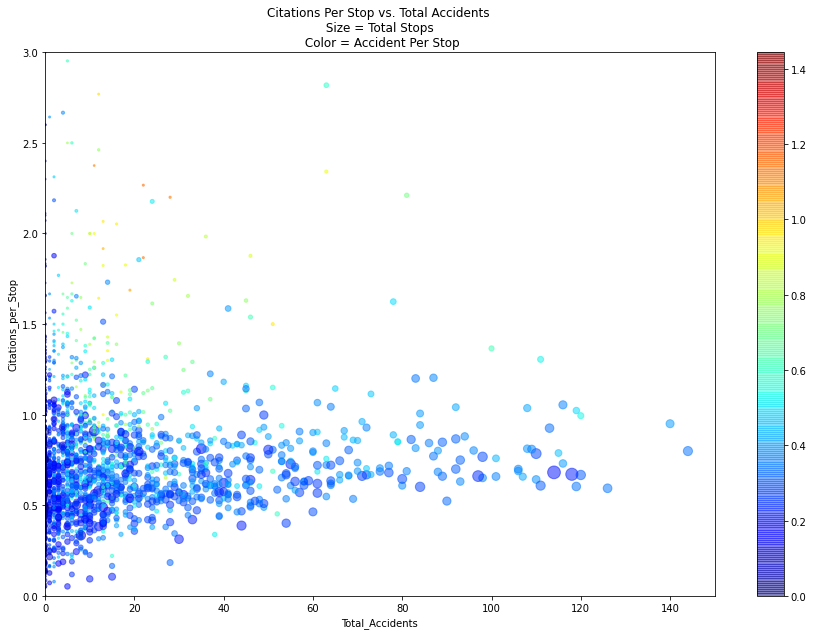

In [161]:
fig, ax1 = plt.subplots()

geo_df.plot(kind='scatter', y="Citations_per_Stop", x="Total_Accidents", s=np.power(geo_df['Total_Stops'], .55), figsize=(15,10), ylim=(0,3), xlim=(0,150), ax=ax1, legend=True, c=np.power(geo_df['Accidents_per_Stop'], .35), cmap='jet', alpha=.5)

plt.title("Citations Per Stop vs. Total Accidents \n Size = Total Stops \n Color = Accident Per Stop")

In [ ]:
race_str = ''.join([f'pct_Stops_{race} + ' for race in race_set-{'NATIVE AMERICAN', 'OTHER'}])[:-3]
race_str

In [166]:
mod = smf.wls(formula=f'Citations_per_Stop ~ Total_Accidents + {race_str}', data=geo_df, weights=geo_df['Total_Stops'])
res = mod.fit(cov_type='HC3')
print(res.summary())

                            WLS Regression Results                            
Dep. Variable:     Citations_per_Stop   R-squared:                       0.473
Model:                            WLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     12.15
Date:                Fri, 02 Apr 2021   Prob (F-statistic):           1.27e-11
Time:                        17:44:48   Log-Likelihood:                -1677.5
No. Observations:                2014   AIC:                             3367.
Df Residuals:                    2008   BIC:                             3401.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.5605      0

### Citations per Stop vs. Total Accidents - Tiles with $\geq 600$ stops

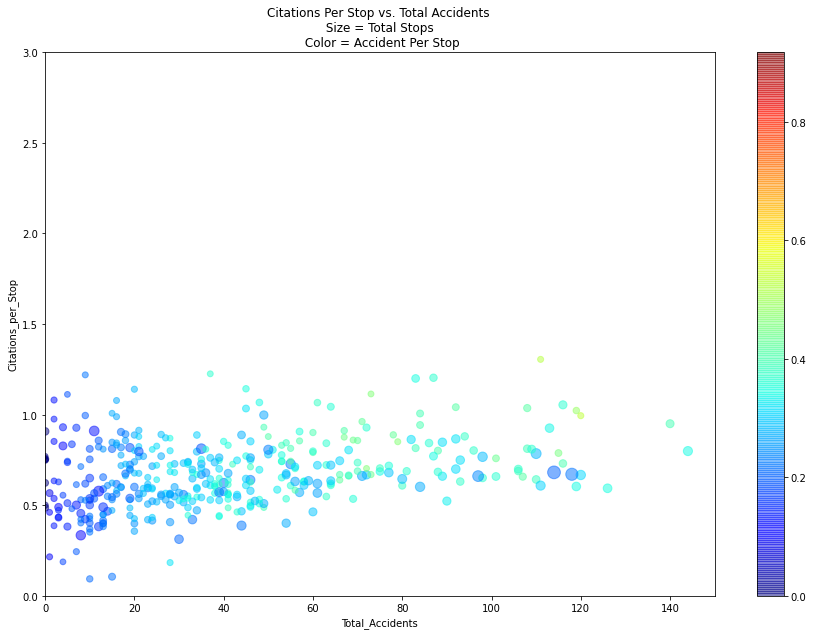

In [162]:
geo_df_subset = geo_df[geo_df['Total_Stops']>=600]

fig, ax1 = plt.subplots()

geo_df_subset.plot(kind='scatter', y="Citations_per_Stop", x="Total_Accidents", s=np.power(geo_df_subset['Total_Stops'], .55), figsize=(15,10), ylim=(0,3), xlim=(0,150), ax=ax1, legend=True, c=np.power(geo_df_subset['Accidents_per_Stop'], .35), cmap='jet', alpha=.5)

plt.title("Citations Per Stop vs. Total Accidents \n Size = Total Stops \n Color = Accident Per Stop")

del geo_df_subset

In [ ]:
fig, ax1 = plt.subplots()

geo_df.plot(kind='scatter', y="Citations_per_Stop", x="Total_Accidents", s=np.power(geo_df['Total_Stops'], .55), figsize=(15,10), ylim=(0,3), xlim=(0,150), ax=ax1, legend=True, c=np.power(geo_df['Citations_per_Stop'], .35), cmap='jet', alpha=.5)

plt.title("Total_Accidents vs. Stops \n Size = Total Stops \n Color = Citations Per Stop")

In [234]:
np.corrcoef(geo_df[geo_df['Total_Stops']>lower_bound]['Total_Stops'], geo_df[geo_df['Total_Stops']>lower_bound]['Total_Accidents'])

array([[1.        , 0.42919404],
       [0.42919404, 1.        ]])

## Regression Analysis

In [228]:
geo_df['Total_Accidents'] = geo_df['Total_Accidents']
geo_df['Total_Stops'] = geo_df['Total_Stops']

In [232]:
mod = smf.wls(formula='Total_Stops ~ Total_Accidents', data=geo_df, weights=geo_df['Total_Stops'])
res = mod.fit()
print(res.summary())

                            WLS Regression Results                            
Dep. Variable:            Total_Stops   R-squared:                       0.185
Model:                            WLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     457.7
Date:                Fri, 02 Apr 2021   Prob (F-statistic):           1.14e-91
Time:                        01:59:59   Log-Likelihood:                -19243.
No. Observations:                2014   AIC:                         3.849e+04
Df Residuals:                    2012   BIC:                         3.850e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1665.5838     47.918     

# Conclusion from above - Accidents explain 18.5% of the variation in MCPD Stops

Note: this is probably an overestimate, since we likely suffer from OVB of popularity of roads - the more popular a road is, the more likely police *and* civilians are to drive on it - therefore, civilians are more likely to get into accidents, and police are more likely to see civilians and pull them over. 18.5% is honestly lower than I would expect if MCPD assigned officers irrespective of accidents.

**EXPLAIN THIS IN PLAIN ENGLISH**

## Is race a better predictor than accidents?

In [19]:
# for race in race_set-{'NATIVE AMERICAN'}:
#     geo_df[f'pct_Stops_{race}'] = geo_df[f'% Stops {race}']

In [91]:
race_str = ''.join([f'pct_Stops_{race} + ' for race in race_set-{'NATIVE AMERICAN', 'OTHER'}])[:-3]
race_str

'pct_Stops_HISPANIC + pct_Stops_WHITE + pct_Stops_BLACK + pct_Stops_ASIAN'

In [254]:
race_mod = smf.wls(formula=f'Total_Stops ~ Total_Accidents + {race_str}', data=geo_df, weights=geo_df['Total_Stops'])
race_res = race_mod.fit()
print(race_res.summary())

                            WLS Regression Results                            
Dep. Variable:            Total_Stops   R-squared:                       0.252
Model:                            WLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     135.4
Date:                Fri, 02 Apr 2021   Prob (F-statistic):          6.30e-124
Time:                        02:12:06   Log-Likelihood:                -19157.
No. Observations:                2014   AIC:                         3.833e+04
Df Residuals:                    2008   BIC:                         3.836e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1283.5894   1726

## Race is a better predictor of MCPD stops than accidents

Race explains 25% of the variation in MCPD stops.

# Race vs. Citations_per_Stop

In [83]:
geo_df['Accidents_per_Stop'].max()

2.857142857142857

                            WLS Regression Results                            
Dep. Variable:     Citations_per_Stop   R-squared:                       0.032
Model:                            WLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.837
Date:                Fri, 02 Apr 2021   Prob (F-statistic):             0.0929
Time:                        13:35:26   Log-Likelihood:                -309.21
No. Observations:                 423   AIC:                             622.4
Df Residuals:                     421   BIC:                             630.5
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6211      0

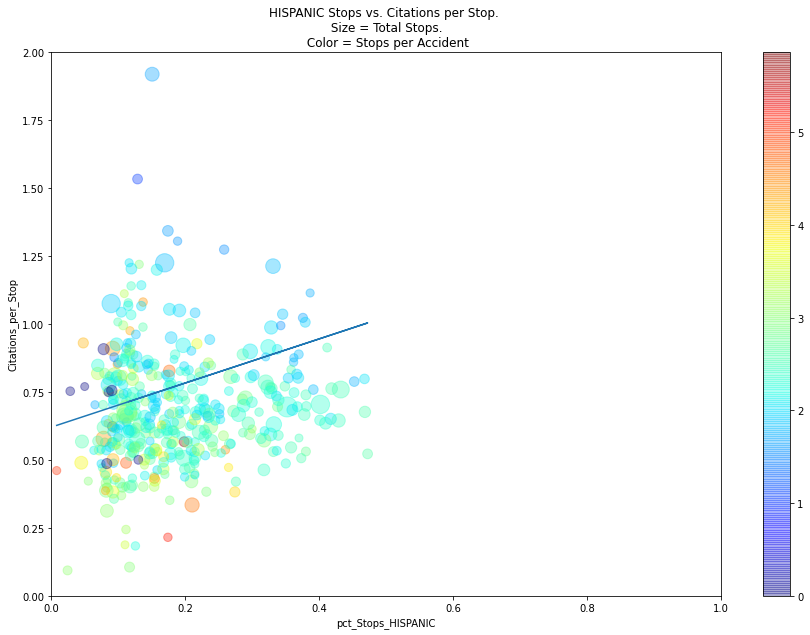

                            WLS Regression Results                            
Dep. Variable:     Citations_per_Stop   R-squared:                       0.036
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     9.092
Date:                Fri, 02 Apr 2021   Prob (F-statistic):            0.00272
Time:                        13:35:26   Log-Likelihood:                -308.31
No. Observations:                 423   AIC:                             620.6
Df Residuals:                     421   BIC:                             628.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9925      0.099     

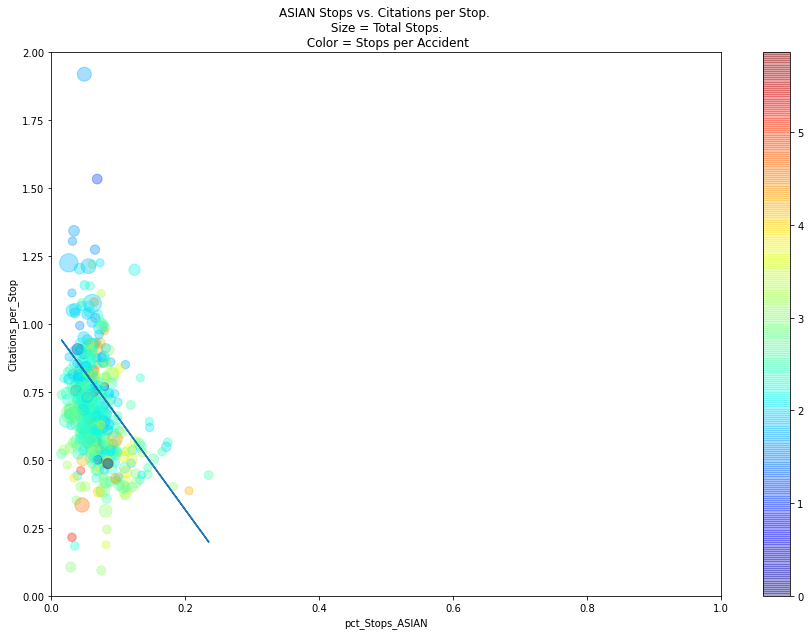

                            WLS Regression Results                            
Dep. Variable:     Citations_per_Stop   R-squared:                       0.051
Model:                            WLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     7.364
Date:                Fri, 02 Apr 2021   Prob (F-statistic):            0.00693
Time:                        13:35:26   Log-Likelihood:                -304.89
No. Observations:                 423   AIC:                             613.8
Df Residuals:                     421   BIC:                             621.9
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.1341      0.159     

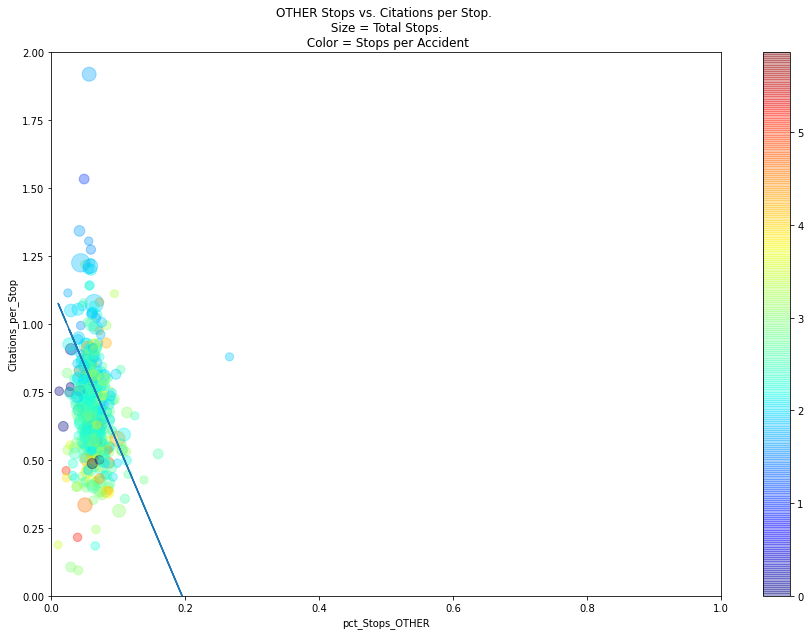

                            WLS Regression Results                            
Dep. Variable:     Citations_per_Stop   R-squared:                       0.027
Model:                            WLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     7.271
Date:                Fri, 02 Apr 2021   Prob (F-statistic):            0.00729
Time:                        13:35:27   Log-Likelihood:                -310.31
No. Observations:                 423   AIC:                             624.6
Df Residuals:                     421   BIC:                             632.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5949      0.071     

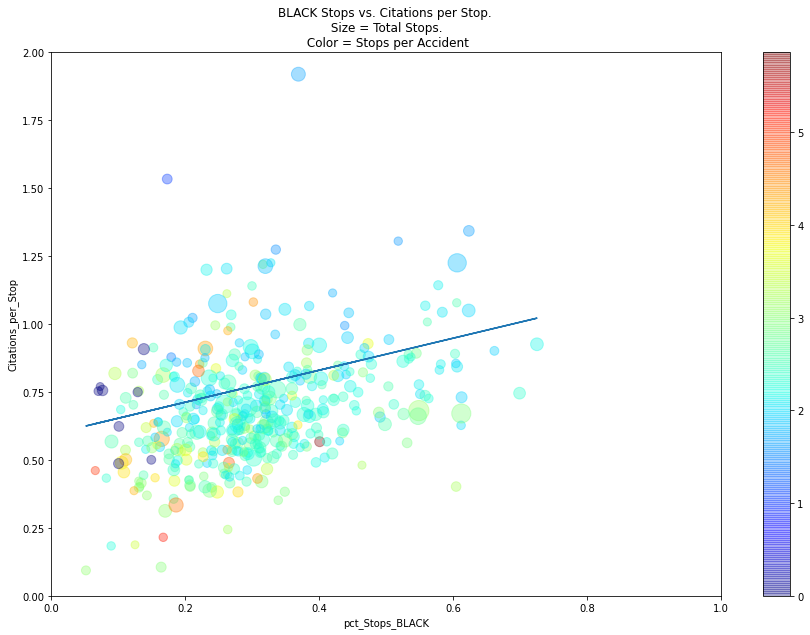

                            WLS Regression Results                            
Dep. Variable:     Citations_per_Stop   R-squared:                       0.038
Model:                            WLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     8.688
Date:                Fri, 02 Apr 2021   Prob (F-statistic):            0.00338
Time:                        13:35:27   Log-Likelihood:                -307.80
No. Observations:                 423   AIC:                             619.6
Df Residuals:                     421   BIC:                             627.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9934      0.102     

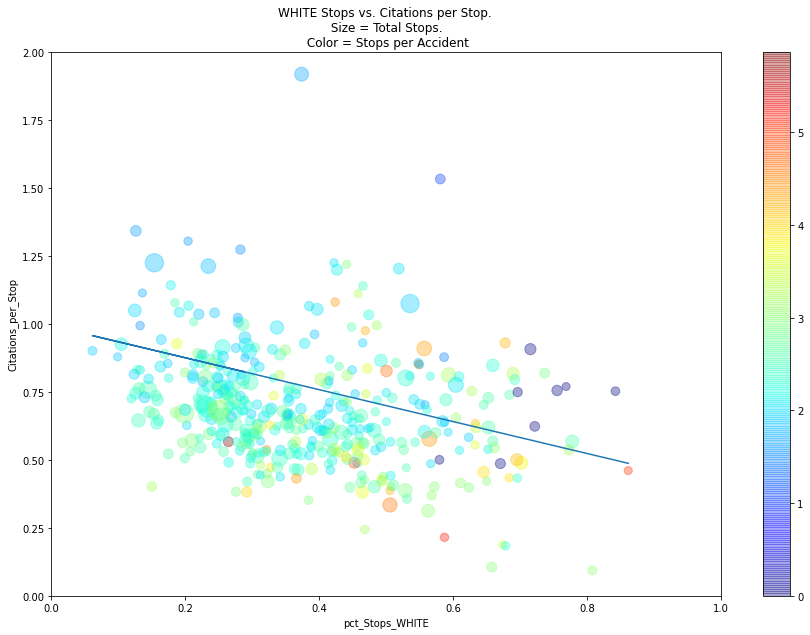

In [116]:
geo_df_subset = geo_df[geo_df['Total_Stops']>=lower_bound]

for race in race_set-{'NATIVE AMERICAN'}:
    
    reg = smf.wls(formula=f'Citations_per_Stop ~ pct_Stops_{race}', data=geo_df_subset, weights=geo_df_subset['Total_Stops']).fit(cov_type='HC3')
    print(reg.summary())
    
    fig, ax1 = plt.subplots()
    geo_df_subset.plot(kind='scatter', y="Citations_per_Stop", x=f"pct_Stops_{race}", s=np.power(geo_df_subset['Total_Stops'], .65), figsize=(15,10), ylim=(0,2), xlim=(0,1), ax=ax1, legend=True, c=np.power(geo_df_subset['Stops_per_Accident'], .25), cmap='jet', alpha=.35)
    ax1.plot(geo_df_subset[f'pct_Stops_{race}'], reg.predict())
    plt.title(f"{race} Stops vs. Citations per Stop. \n Size = Total Stops. \n Color = Stops per Accident")
    plt.show()

In [142]:
pip install mpld3

  Created wheel for mpld3: filename=mpld3-0.5.2-py3-none-any.whl size=200617 sha256=d05151abe2c7d4725f53cf6c655fdcd2f80f8a6682a8f60e3f99661b43d0466e
  Stored in directory: c:\users\mikha\appdata\local\pip\cache\wheels\d1\fb\75\f5b4dc0a7eb149b7ca745beeced5a286e4e8ab3a8cdb45bd1b
Successfully built mpld3
Note: you may need to restart the kernel to use updated packages.


In [144]:
import mpld3

In [150]:
geo_df_subset = geo_df[geo_df['Total_Stops']>=lower_bound]

for race in race_set-{'NATIVE AMERICAN'}:
    
    yvar = 'pct_Altered'
    xvar = f'pct_Stops_{race}'
    
    reg = smf.wls(formula=f'{yvar} ~ {xvar}', data=geo_df_subset, weights=geo_df_subset['Total_Stops']).fit(cov_type='HC3')
    print(reg.summary())
    
    fig, ax1 = plt.subplots()
    geo_df_subset.plot(kind='scatter', y=yvar, x=xvar, s=np.power(geo_df_subset['Total_Stops'], .65), figsize=(15,10), xlim=(0,1), ylim=(0,1), ax=ax1, legend=True, c=np.power(geo_df_subset['Citations_per_Stop'], .25), cmap='jet', alpha=.5)
    ax1.plot(geo_df_subset[xvar], reg.predict())
    plt.title(f"{xvar} vs. {yvar}. \n Size = Total Stops. \n Color = Citations_per_Stop")
#     plt.show()
    mpld3.display(fig)

                            WLS Regression Results                            
Dep. Variable:            pct_Altered   R-squared:                       0.004
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                    0.8116
Date:                Fri, 02 Apr 2021   Prob (F-statistic):              0.368
Time:                        17:25:36   Log-Likelihood:                -82.654
No. Observations:                 423   AIC:                             169.3
Df Residuals:                     421   BIC:                             177.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8119      0

                            WLS Regression Results                            
Dep. Variable:     Stops_per_Accident   R-squared:                       0.038
Model:                            WLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     19.95
Date:                Fri, 02 Apr 2021   Prob (F-statistic):           1.02e-05
Time:                        13:52:40   Log-Likelihood:                -2566.4
No. Observations:                 423   AIC:                             5137.
Df Residuals:                     421   BIC:                             5145.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             96.2225     12

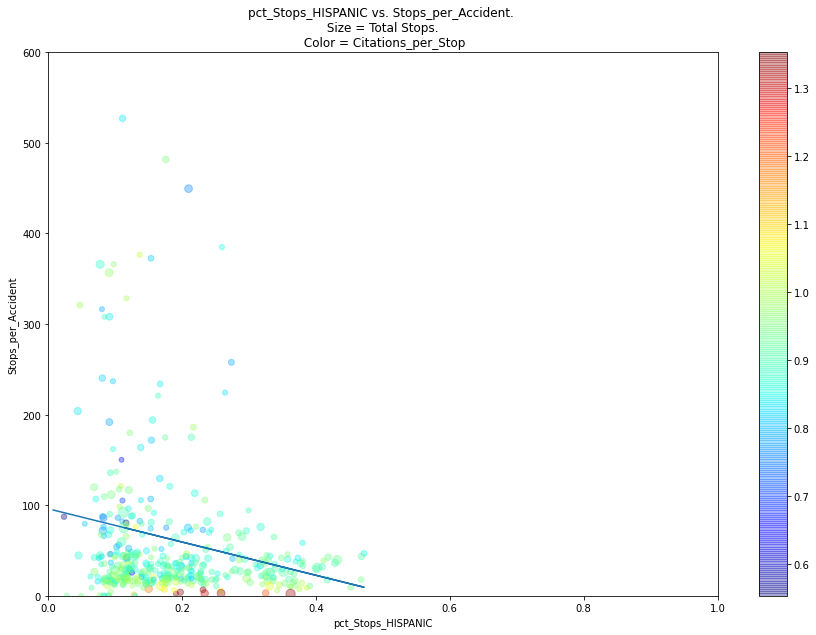

                            WLS Regression Results                            
Dep. Variable:     Stops_per_Accident   R-squared:                       0.016
Model:                            WLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     7.216
Date:                Fri, 02 Apr 2021   Prob (F-statistic):            0.00751
Time:                        13:52:40   Log-Likelihood:                -2571.0
No. Observations:                 423   AIC:                             5146.
Df Residuals:                     421   BIC:                             5154.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          30.3636     11.495     

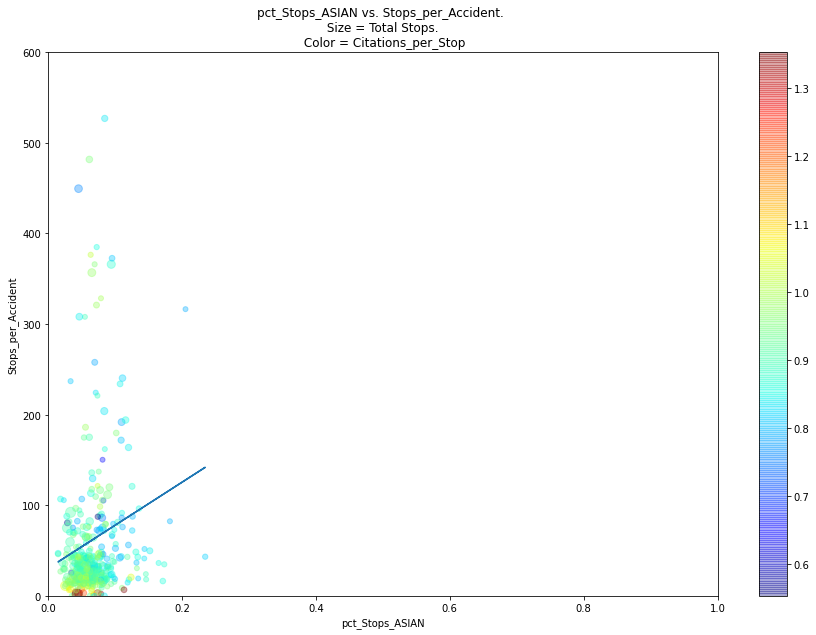

                            WLS Regression Results                            
Dep. Variable:     Stops_per_Accident   R-squared:                       0.008
Model:                            WLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.918
Date:                Fri, 02 Apr 2021   Prob (F-statistic):              0.167
Time:                        13:52:40   Log-Likelihood:                -2572.8
No. Observations:                 423   AIC:                             5150.
Df Residuals:                     421   BIC:                             5158.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          31.4139     20.488     

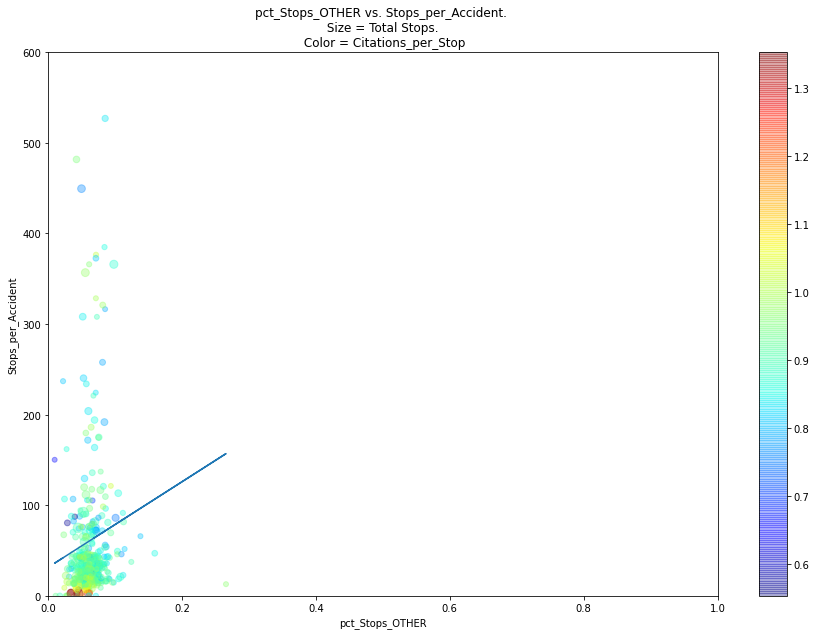

                            WLS Regression Results                            
Dep. Variable:     Stops_per_Accident   R-squared:                       0.032
Model:                            WLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     9.348
Date:                Fri, 02 Apr 2021   Prob (F-statistic):            0.00238
Time:                        13:52:41   Log-Likelihood:                -2567.7
No. Observations:                 423   AIC:                             5139.
Df Residuals:                     421   BIC:                             5147.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         102.1495     16.617     

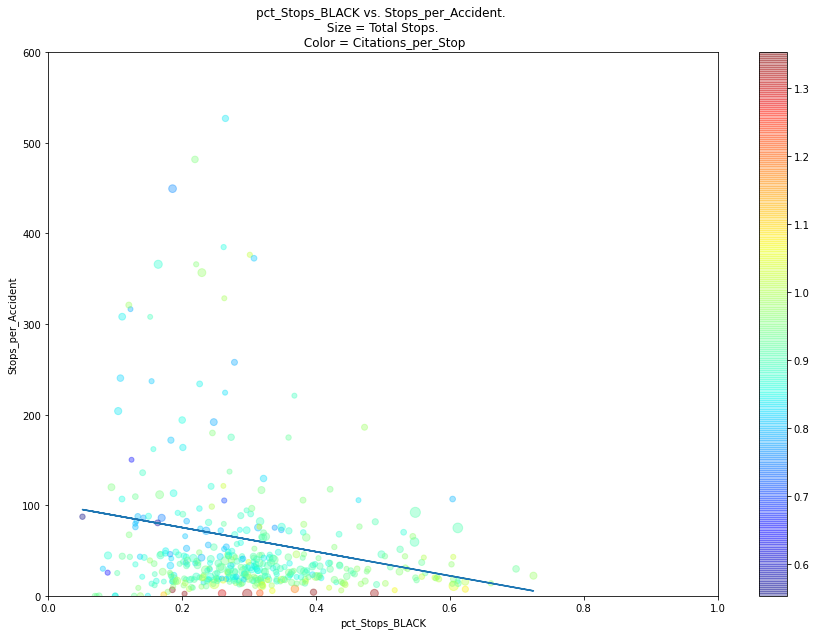

                            WLS Regression Results                            
Dep. Variable:     Stops_per_Accident   R-squared:                       0.060
Model:                            WLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     15.59
Date:                Fri, 02 Apr 2021   Prob (F-statistic):           9.22e-05
Time:                        13:52:41   Log-Likelihood:                -2561.4
No. Observations:                 423   AIC:                             5127.
Df Residuals:                     421   BIC:                             5135.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.5915     11.760     

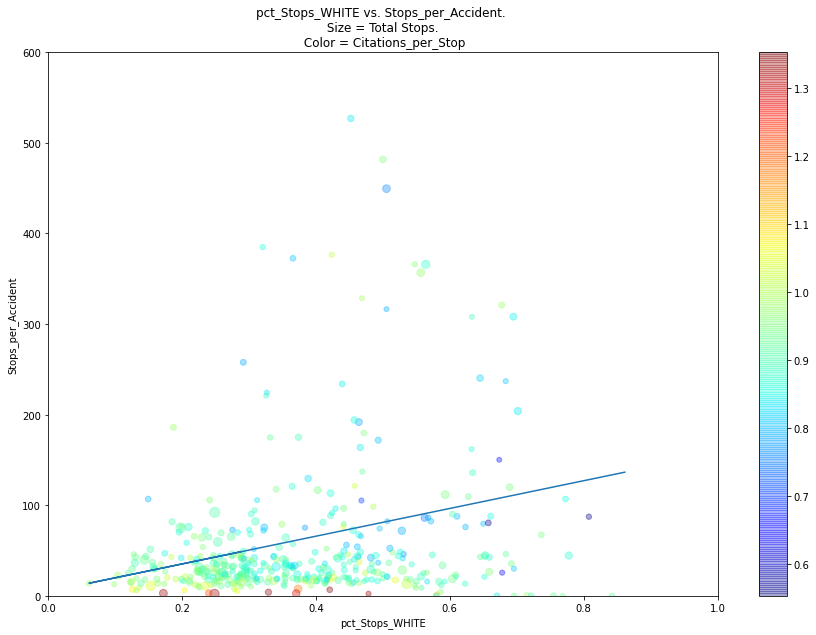

In [128]:
geo_df_subset = geo_df[geo_df['Total_Stops']>=lower_bound]

for race in race_set-{'NATIVE AMERICAN'}:
    
    yvar = 'Stops_per_Accident'
    xvar = f'pct_Stops_{race}'
    
    reg = smf.wls(formula=f'{yvar} ~ {xvar}', data=geo_df_subset, weights=geo_df_subset['Total_Stops']).fit(cov_type='HC3')
    print(reg.summary())
    
    fig, ax1 = plt.subplots()
    geo_df_subset.plot(kind='scatter', y=yvar, x=xvar, s=np.power(geo_df_subset['Total_Stops'], .5), figsize=(15,10), xlim=(0,1), ylim=(0,600), ax=ax1, legend=True, c=np.power(geo_df_subset['Citations_per_Stop'], .25), cmap='jet', alpha=.35)
    ax1.plot(geo_df_subset[xvar], reg.predict())
    plt.title(f"{xvar} vs. {yvar}. \n Size = Total Stops. \n Color = Citations_per_Stop")
    plt.show()

In [ ]:
geo_df['Distance_to_Closest_Station']

'pct_Stops_HISPANIC + pct_Stops_WHITE + pct_Stops_BLACK'

In [103]:
# race_str-{"ASIAN", "OTHER"}
race_mod = smf.wls(formula=f'Total_Stops ~ Total_Accidents + {race_str[:-18]} + Distance_to_Closest_Station', data=geo_df, weights=geo_df['Total_Stops'])
race_res = race_mod.fit(cov_type='HC3')
print(race_res.summary())



                            WLS Regression Results                            
Dep. Variable:            Total_Stops   R-squared:                       0.256
Model:                            WLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     8.004
Date:                Fri, 02 Apr 2021   Prob (F-statistic):           1.75e-07
Time:                        13:24:14   Log-Likelihood:                -19152.
No. Observations:                2014   AIC:                         3.832e+04
Df Residuals:                    2008   BIC:                         3.835e+04
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [104]:
race_mod = smf.wls(formula=f'Total_Stops ~ Total_Accidents', data=geo_df, weights=geo_df['Total_Stops'])
race_res = race_mod.fit(cov_type='HC3')
print(race_res.summary())

                            WLS Regression Results                            
Dep. Variable:            Total_Stops   R-squared:                       0.185
Model:                            WLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                    0.4694
Date:                Fri, 02 Apr 2021   Prob (F-statistic):              0.493
Time:                        13:25:08   Log-Likelihood:                -19243.
No. Observations:                2014   AIC:                         3.849e+04
Df Residuals:                    2012   BIC:                         3.850e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1665.5838    346.493     

<AxesSubplot:xlabel='Accidents per Stop', ylabel='Total Stops'>

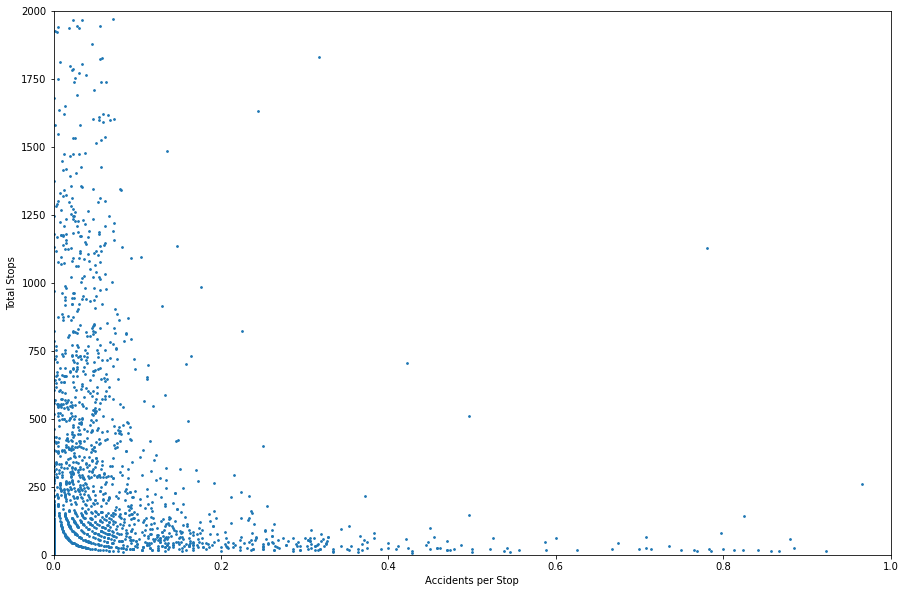

In [147]:
geo_df.plot(kind='scatter', y="Total_Stops", x="Accidents_per_Stop", s=3, figsize=(15,10), ylim=(0,2000), xlim=(0,1))

<AxesSubplot:xlabel='Total Accidents', ylabel='Accidents per Stop'>

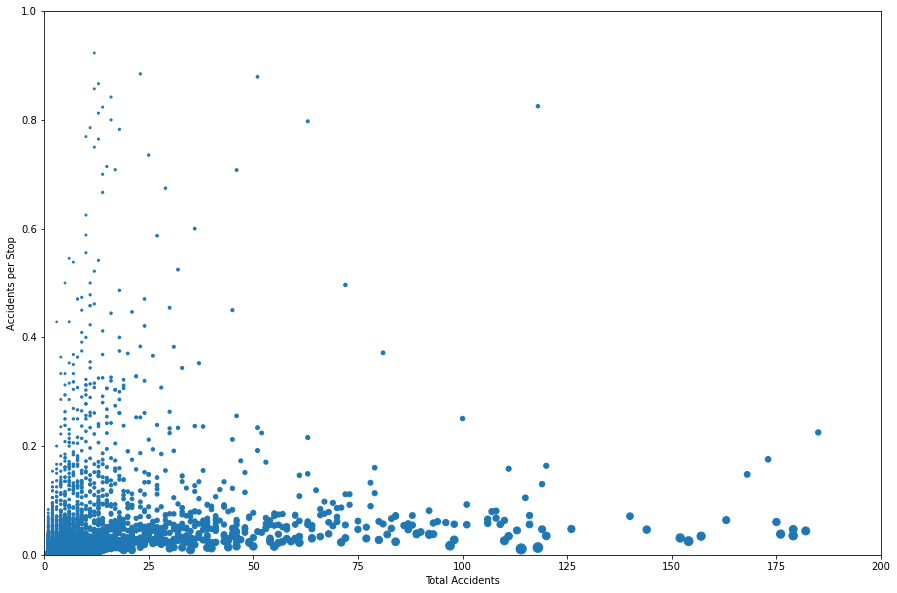

In [157]:
geo_df.plot(kind='scatter', x="Total_Accidents", y="Accidents_per_Stop", figsize=(15,10), ylim=(0,1), xlim=(0,200), s=np.power(geo_df['Total_Stops'], .5))